Number of users: 610, number of items: 9724.


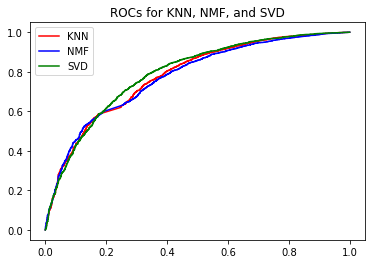

('Area under the curve for KNN: ', 0.7807724293652648)
('Area under the curve for NMF: ', 0.7754967382532397)
('Area under the curve for SVD: ', 0.7911511701915437)


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.prediction_algorithms.predictions import Prediction
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD

def GetDataframe():
    df = pd.read_csv("C:/Users/AJ/Desktop/ml-latest-small/ratings.csv")
    df.drop('timestamp', axis=1, inplace=True)
    num_users = df.userId.unique().shape[0]
    num_items = df.movieId.unique().shape[0]

    print('Number of users: %d, number of items: %d.' % (num_users, num_items))
    return df, num_users, num_items

def GetRMatrix(data):
    X = data.values
    users = X[:,0]
    movies = X[:,1]

    movie_map = {}
    reverse_movie_map = {}
    new_id = 0
    for idx in range(len(movies)):
        item = int(movies[idx])
        if item not in movie_map:
            movie_map[item] = new_id
            reverse_movie_map[new_id] = item
            new_id += 1

    ratings = X[:,2]
    num_ratings = int(len(ratings))
    R = np.zeros((num_users, num_items))

    for i in np.arange(num_ratings):
        R[int(users[i]-1), movie_map[movies[i]]] = ratings[i]
        
    return R, users, movies, ratings, movie_map, reverse_movie_map

df, num_users, num_items = GetDataframe()
R, users, movies, ratings, movie_map, reverse_movie_map = GetRMatrix(df)


best_k = 40
sim_options = {'name': 'pearson'}



clf_knn = KNNWithMeans(k=best_k, sim_options=sim_options, verbose=False)

clf_nmf=NMF(n_factors=20, biased=False)

clf_svd = SVD(n_factors=20)


def give_roc_stuff(algo, df=df, thresh=2):
    reader_bin = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df,reader_bin)
    X=df.values
    y_true = X[:,2]
    
    trainset, testset = train_test_split(data, test_size=.1)
    predictions = algo.fit(trainset).test(testset)
    test_array=np.array(testset)
    y_true=test_array[:,2]
    above_thresh=y_true>thresh
    below_thresh=y_true<=thresh
    y_true[above_thresh]=1
    y_true[below_thresh]=0
    pred_array = np.array(predictions)
    scores=pred_array[:,3]
    fpr, tpr, thresholds=roc_curve(y_true, scores)
    auc_c = roc_auc_score(y_true, scores)
    return fpr, tpr, auc_c

fpr_knn, tpr_knn, auc_knn = give_roc_stuff(clf_knn)
fpr_nmf, tpr_nmf, auc_nmf, = give_roc_stuff(clf_nmf)
fpr_svd, tpr_svd, auc_svd = give_roc_stuff(clf_svd)

plt.plot(fpr_knn, tpr_knn, 'r') # plotting t, a separately 
plt.plot(fpr_nmf, tpr_nmf, 'b') # plotting t, b separately 
plt.plot(fpr_svd, tpr_svd, 'g') # plotting t, c separately 
plt.legend(['KNN','NMF','SVD'])
plt.title('ROCs for KNN, NMF, and SVD')
plt.show()




print('Area under the curve for KNN: ', auc_knn)
print('Area under the curve for NMF: ', auc_nmf)
print('Area under the curve for SVD: ', auc_svd)
